# Module 4 - Breast Cancer Analysis 

This notebook is a submission for module 4c.

You can:
    add further cells or text blocks to extend or further explain your solution
    add further functions

Dont:
    rename functions
   

In [63]:
# Fixed dependencies - do not remove or change.
import pytest
import pandas as pd
import numpy as np


# Import your dependencies
import keras.models
import keras.layers 
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

In [64]:
# Import data

def import_local_data(file_path):
    """This function needs to import the data file into collab and return a pandas dataframe
    """
    return pd.read_excel(file_path)

In [3]:
local_file_path = "https://github.com/agreenhalgh/deep-learning-training/blob/master/breast-cancer.xls?raw=true"

In [87]:
# Dont change
raw_data = import_local_data(local_file_path)

### Conduct exploratory data analysis and explain your key findings

In [5]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 286 entries, 0 to 285
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   age          286 non-null    object
 1   menopause    286 non-null    object
 2   tumor-size   286 non-null    object
 3   inv-nodes    286 non-null    object
 4   node-caps    286 non-null    object
 5   deg-malig    286 non-null    int64 
 6   breast       286 non-null    object
 7   breast-quad  286 non-null    object
 8   irradiat     286 non-null    object
 9   Class        286 non-null    object
dtypes: int64(1), object(9)
memory usage: 22.5+ KB


In [6]:
raw_data.head()

,age,menopause,tumor-size,inv-nodes,node-caps,deg-malig,breast,breast-quad,irradiat,Class
0,40-49,premeno,15-19,0-2,yes,3,right,left_up,no,recurrence-events
1,50-59,ge40,15-19,0-2,no,1,right,central,no,no-recurrence-events
2,50-59,ge40,35-39,0-2,no,2,left,left_low,no,recurrence-events
3,40-49,premeno,35-39,0-2,yes,3,right,left_low,yes,no-recurrence-events
4,40-49,premeno,30-34,2019-05-03 00:00:00,yes,2,left,right_up,no,recurrence-events


Numerical Features: age (Discrete), tumor-size (Discrete), inv-nodes (Discrete), deg-malig (Discrete) 

Categorical Features: menopause, mode-caps, breast, breast-quad, irradiat, Class

Some fields have been corrupted by converting to XLS

In [7]:
raw_data["tumor-size"][raw_data["tumor-size"] == datetime(2014, 10, 1, 0, 0)] = "10-14"
raw_data["tumor-size"][raw_data["tumor-size"] == datetime(2019, 9, 5, 0, 0)] = "5-9"
raw_data["inv-nodes"][raw_data["inv-nodes"] == datetime(2019, 5, 3, 0, 0)] = "3-5"
raw_data["inv-nodes"][raw_data["inv-nodes"] == datetime(2019, 8, 6, 0, 0)] = "6-8"
raw_data["inv-nodes"][raw_data["inv-nodes"] == datetime(2019, 11, 9, 0, 0)] = "9-11"
raw_data["inv-nodes"][raw_data["inv-nodes"] == datetime(2014, 12, 1, 0, 0)] = "12-14"

/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipyk

In [8]:
raw_data.isnull().sum()

age            0
menopause      0
tumor-size     0
inv-nodes      0
node-caps      0
deg-malig      0
breast         0
breast-quad    0
irradiat       0
Class          0
dtype: int64

In [9]:
raw_data.describe()

,deg-malig
count,286.000000
mean,2.048951
std,0.738217
min,1.000000
25%,2.000000
50%,2.000000
75%,3.000000
max,3.000000


There are no null values. 

Calculate the recurrence rate

In [10]:

recurrence = raw_data['Class'].value_counts()
recurrence['recurrence-events']/recurrence.sum()*100

29.72027972027972

Distribution of recurrence isn't clearly linked with breast side.

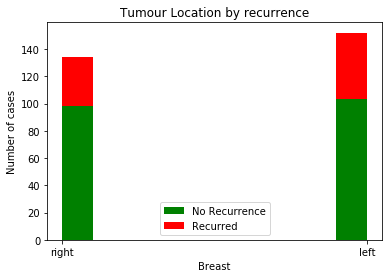

In [11]:
plt.hist(x = [raw_data[raw_data['Class']=='no-recurrence-events']['breast'], raw_data[raw_data['Class']=='recurrence-events']['breast']], 
         stacked=True, color = ['g','r'],label = ['No Recurrence','Recurred'])
plt.title('Tumour Location by recurrence')
plt.xlabel('Breast')
plt.ylabel('Number of cases')
plt.legend()

Degree of malignancy is correlated with age, tending to be higher between 30-50, more evenly distributed between 50 and 70, and becoming less after 70.

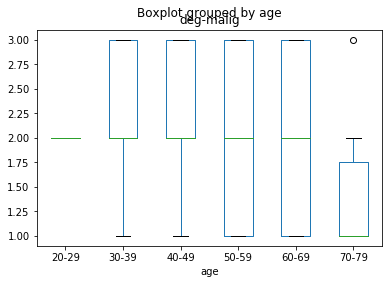

In [12]:
raw_data.boxplot(column='deg-malig', by='age', grid=False )

There are significantly more instances in the left lower and left upper quadrants. A small number of quadrants are recorded as `?`

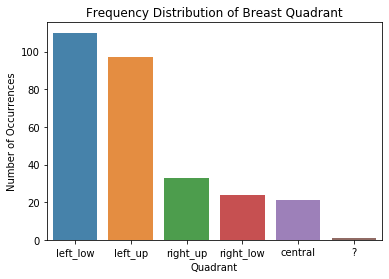

In [13]:
quad_count = raw_data['breast-quad'].value_counts()
sns.barplot(quad_count.index, quad_count.values, alpha=0.9)
plt.title('Frequency Distribution of Breast Quadrant')
plt.ylabel('Number of Occurrences')
plt.xlabel('Quadrant')
plt.show()

Centrally located tumors are more likely to be non-recurrent

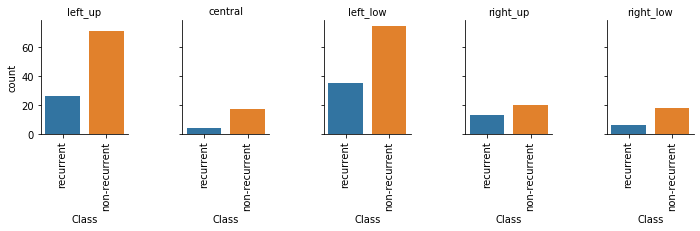

In [14]:
g = sns.catplot("Class", col="breast-quad", data=raw_data[raw_data['breast-quad']!='?'],kind="count", height=2.5, aspect=.8,orient=90)
g.set_xticklabels(["recurrent", "non-recurrent"], rotation=90).set_titles("{col_name}")

In [29]:
raw_data['menopause'].unique()

array(['premeno', 'ge40', 'lt40'], dtype=object)

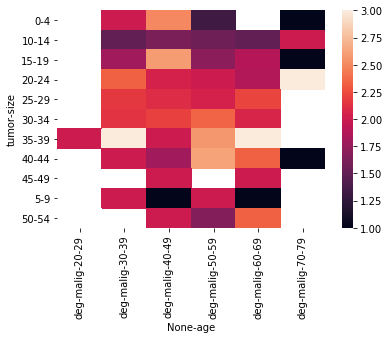

In [16]:
tumours = raw_data.pivot_table(index='tumor-size', columns='age')
g = sns.heatmap(tumours)

In [17]:
sns.catplot(x="inv-nodes", y="tumor-size", data=raw_data);

ValueError: Neither the `x` nor `y` variable appears to be numeric.

In [ ]:
raw_data['age'].unique()

The age column is classified into ranges. Take the midpoint of each age as the value. 

In [ ]:
raw_data['age'] = raw_data['age'].str.split(pat = '-', n=1, expand=True)
raw_data['age'] = pd.to_numeric(raw_data['age'])+5

inv-nodes, breast, irradiat and Class are all binary

Menopause is another categorical variable. Use one hot encoding to split in to seperate fields

In [ ]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer 
ct = ColumnTransformer([("Categorize_Menopause", OneHotEncoder(),['menopause'])], remainder="passthrough")
raw_data = ct.fit_transform(raw_data)  

The Class column contains the outcome, which is a binary classification. This will become the `y` dataset. 

In [ ]:
raw_data

In [ ]:
# Explain your key findings

Create any data pre-processing that you will conduct on seen and unseen data.  Regardless of the model you use, this dataframe must contain only numeric features and have a strategy for any expected missing values. Any objects can that are needed to handle the test data that are dependent on the training data can be stored in the model class.  You are recommended to use sklearn Pipelines or similar functionality to ensure reproduccibility.

In [ ]:
# Split your data so that you can test the effectiveness of your model


In [ ]:
# Populate preprocess_training_data and preprocess_test_data to

In [88]:
class Module4_Model(object):
    
    def __init__(self):
        self.model = None
        
        categorical_columns = ['node-caps', 'breast', 'irradiat', 'Class' ]
        multi_category_columns = ['breast-quad' ]
        
        self.pipeline = Pipeline(steps=[
            ('fix_ranges_as_dates', FunctionTransformer(self.date_to_range)),
            ('create_midpoint_from_ranges', FunctionTransformer(self.range_to_midpoint)),
#            ('map_menopause', FunctionTransformer(self.map_categories)),
            ('encode_categories', ColumnTransformer(transformers=[
                    ('categorical', LabelEncoder(), categorical_columns),
                    ('multi-category', OneHotEncoder(), multi_category_columns)
                ],
                remainder='passthrough')
            )
        ])
        
    def date_to_range(self, X):
        """
        Some of the range categories have been corrupted by saving as XLS rather than CSV and are now formated as dates.
        Change these date values to the correct range 
        """
        X["tumor-size"] = (
            np.select(
                condlist=[
                    X["tumor-size"] == datetime(2014, 10, 1, 0, 0),
                    X["tumor-size"] == datetime(2019, 9, 5, 0, 0)
                ],
                choicelist=[
                    '10-14',
                    '5-9'
                ], 
                default=X["tumor-size"])
        )
        X["inv-nodes"] = (
            np.select(
                condlist=[
                    X["inv-nodes"] == datetime(2019, 5, 3, 0, 0),
                    X["inv-nodes"] == datetime(2019, 8, 6, 0, 0),
                    X["inv-nodes"] == datetime(2019, 11, 9, 0, 0),
                    X["inv-nodes"] == datetime(2014, 12, 1, 0, 0)
                ],
                choicelist=[
                    "3-5",
                    "6-8",
                    "9-11",
                    "12-14"
                ], 
                default=X["inv-nodes"])
        )
        return X

    def range_to_midpoint(self, X):
        """
        For range categories in the form `4-7` update to a number at the midpoint of the range
        """
        X['age'] =  X['age'].str.split('-').apply(lambda l: pd.to_numeric(l[0]) + (pd.to_numeric(l[1])-pd.to_numeric(l[0]))/2)
        X['tumor-size'] =  X['tumor-size'].str.split('-').apply(lambda l: pd.to_numeric(l[0]) + (pd.to_numeric(l[1])-pd.to_numeric(l[0]))/2)
        X['inv-nodes'] =  X['inv-nodes'].str.split('-').apply(lambda l: pd.to_numeric(l[0]) + (pd.to_numeric(l[1])-pd.to_numeric(l[0]))/2)
        return X

    def map_categories(self, X):
        """
        Menopause are ordered categories, map them onto ordinal values
        """
        menopause_map = {
            'premeno': 1,
            'lt40': 2,
            'ge40': 3
        }
        X['menopause'] = X['menopause'].map(menopause_map)
        

    def preprocess_training_data(self, training_df):
        """
        This function should conduct
        """
        return processed_df

    def preprocess_test_data(self, test_df):

        return processed_df



In [89]:
m = Module4_Model()
m.pipeline.fit(raw_data)
m.pipeline.transform(raw_data)

TypeError: fit_transform() takes 2 positional arguments but 3 were given

In [23]:
raw_data['tumor-size'].unique()

array(['15-19', '35-39', '30-34', '25-29', '40-44', '10-14', '0-4',
       '20-24', '45-49', '50-54', '5-9'], dtype=object)

In [ ]:
# Dont change
my_model = Module4_Model()

In [ ]:
# Dont change
x_train_processed = my_model.preprocess_training_data(x_train)

In [ ]:
# Create a model

In [ ]:
# Dont change
x_test_processed = my_model.preprocess_test_data(x_test)

In [ ]:
# Train your model

In [ ]:
# use your model to make a prediction on unseen data

In [ ]:
# Asssess the accuracy of your model and explain your key findings